In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from pathlib import Path
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import MultilabelF1Score
from torchmetrics.classification import MultilabelAccuracy
from transformers import BertModel, BertTokenizer
from Bio import SeqIO

In [13]:
torch.manual_seed(42)
np.random.seed(42)
torch.cuda.manual_seed_all(42)

In [14]:
class config:
    num_labels = 500
    n_epochs = 25
    batch_size = 128
    lr = 0.001
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    embeds_dim = 1024

In [15]:
class paths:
    train_ids = "/kaggle/input/protbert-embeddings-for-cafa5/train_ids.npy"    
    train_embeddings = "/kaggle/input/protbert-embeddings-for-cafa5/train_embeddings.npy"
    test_ids = "/kaggle/input/protbert-embeddings-for-cafa5/test_ids.npy"
    test_embeddings = "/kaggle/input/protbert-embeddings-for-cafa5/test_embeddings.npy"
    train_labels_path = "/kaggle/input/cafa-5-protein-function-prediction/Train/train_terms.tsv"
    train_targets_path = "/kaggle/input/cafa5-label-vectors-numpy/train_targets_top500.npy"

In [16]:
class CustomProteinDataset(Dataset):
    def __init__(self, train=True):
        super(CustomProteinDataset).__init__()
        self.train=train
        if train:
            embeds = np.load(paths.train_embeddings)
            ids = np.load(paths.train_ids)
        else:
            embeds = np.load(paths.test_embeddings)
            ids = np.load(paths.test_ids)
        
        embeds_list = []
        for l in range(embeds.shape[0]):
            embeds_list.append(embeds[l,:])
        self.df = pd.DataFrame(data={"EntryID": ids, "embed" : embeds_list})
        
        if train:
            self.labels = np.load(paths.train_targets_path)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        embed = torch.tensor(self.df.iloc[index]["embed"], dtype = torch.float32)
        if self.train:
            targets = torch.tensor(self.labels[index, :], dtype = torch.float32)
            return embed, targets
        else:
            id = self.df.iloc[index]["EntryID"]
            return embed, id

In [17]:
train_dataset = CustomProteinDataset()
test_dataset = CustomProteinDataset(train=False)

In [18]:
len(train_dataset)

142246

In [19]:
class MultiLayerPerceptron(torch.nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MultiLayerPerceptron, self).__init__()
        self.linear1 = torch.nn.Linear(input_dim, 1012)
        self.activation1 = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(1012, 712)
        self.activation2 = torch.nn.ReLU()
        self.linear3 = torch.nn.Linear(712, num_classes)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation1(x)
        x = self.linear2(x)
        x = self.activation2(x)
        x = self.linear3(x)
        return x

In [20]:
class CNN1D(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=3, kernel_size=3, dilation=1, padding=1, stride=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(in_channels=3, out_channels=8, kernel_size=3, dilation=1, padding=1, stride=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=int(8 * input_dim/4), out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)

    def forward(self, x):
        x = x.reshape(x.shape[0], 1, x.shape[1])
        x = self.pool1(nn.functional.relu(self.conv1(x)))
        x = self.pool2(nn.functional.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [21]:
def train(model_type="linear", train_size=0.9):
    train_set, val_set = random_split(train_dataset, lengths = [int(len(train_dataset)*train_size), len(train_dataset)-int(len(train_dataset)*train_size)])
    train_dataloader = DataLoader(train_set, batch_size=config.batch_size, shuffle=True)
    val_dataloader = DataLoader(val_set, batch_size=config.batch_size, shuffle=True)
    
    if model_type == "linear":
        model = MultiLayerPerceptron(input_dim=config.embeds_dim, num_classes=config.num_labels).to(config.device)
    if model_type == "convolutional":
        model = CNN1D(input_dim=config.embeds_dim, num_classes=config.num_labels).to(config.device)
        
    optimizer = torch.optim.Adam(model.parameters(), lr = config.lr)
    scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=1)
    CrossEntropy = torch.nn.CrossEntropyLoss()
    f1_score = MultilabelF1Score(num_labels=config.num_labels).to(config.device)
    n_epochs = config.n_epochs
    
    train_loss_history=[]
    val_loss_history=[]
    
    train_f1score_history=[]
    val_f1score_history=[]
    
    for epoch in range(n_epochs):
        print("EPOCH ", epoch+1)
        ## TRAIN PHASE :
        losses = []
        scores = []
        for embed, targets in tqdm(train_dataloader):
            embed, targets = embed.to(config.device), targets.to(config.device)
            optimizer.zero_grad()
            preds = model(embed)
            loss= CrossEntropy(preds, targets)
            score=f1_score(preds, targets)
            losses.append(loss.item()) 
            scores.append(score.item())
            loss.backward()
            optimizer.step()
        avg_loss = np.mean(losses)
        avg_score = np.mean(scores)
        print("Running Average TRAIN Loss : ", avg_loss)
        print("Running Average TRAIN F1-Score : ", avg_score)
        train_loss_history.append(avg_loss)
        train_f1score_history.append(avg_score)\
        
        losses = []
        scores = []
        for embed, targets in val_dataloader:
            embed, targets = embed.to(config.device), targets.to(config.device)
            preds = model(embed)
            loss= CrossEntropy(preds, targets)
            score=f1_score(preds, targets)
            losses.append(loss.item())
            scores.append(score.item())
        avg_loss = np.mean(losses)
        avg_score = np.mean(scores)
        print("Running Average VAL Loss : ", avg_loss)
        print("Running Average VAL F1-Score : ", avg_score)
        val_loss_history.append(avg_loss)
        val_f1score_history.append(avg_score)
        
        scheduler.step(avg_loss)
        print("\n")
        
    print("TRAINING FINISHED")
    print("FINAL TRAINING SCORE : ", train_f1score_history[-1])
    print("FINAL VALIDATION SCORE : ", val_f1score_history[-1])
    
    losses_history = {"train" : train_loss_history, "val" : val_loss_history}
    scores_history = {"train" : train_f1score_history, "val" : val_f1score_history}
    
    return model, losses_history, scores_history

In [22]:
model, losses_history, scores_history = train(model_type="linear", train_size=0.99)

EPOCH  1


100%|██████████| 1101/1101 [00:13<00:00, 79.67it/s]


Running Average TRAIN Loss :  137.66355030499838
Running Average TRAIN F1-Score :  0.10767678633927757
Running Average VAL Loss :  135.83552932739258
Running Average VAL F1-Score :  0.13245100590089956


EPOCH  2


100%|██████████| 1101/1101 [00:14<00:00, 78.49it/s]


Running Average TRAIN Loss :  134.9062374714393
Running Average TRAIN F1-Score :  0.14278392259583053
Running Average VAL Loss :  133.63822809855142
Running Average VAL F1-Score :  0.14704437429706255


EPOCH  3


100%|██████████| 1101/1101 [00:13<00:00, 80.29it/s]


Running Average TRAIN Loss :  133.8213019583249
Running Average TRAIN F1-Score :  0.15483962136111837
Running Average VAL Loss :  142.6841138203939
Running Average VAL F1-Score :  0.1631909782687823


EPOCH  4


100%|██████████| 1101/1101 [00:14<00:00, 78.35it/s]


Running Average TRAIN Loss :  133.06755566228856
Running Average TRAIN F1-Score :  0.16230648742493015
Running Average VAL Loss :  131.1871509552002
Running Average VAL F1-Score :  0.16050563318034014


EPOCH  5


100%|██████████| 1101/1101 [00:13<00:00, 81.51it/s]


Running Average TRAIN Loss :  132.46709789307306
Running Average TRAIN F1-Score :  0.1676875043399869
Running Average VAL Loss :  136.504789352417
Running Average VAL F1-Score :  0.17339928448200226


EPOCH  6


100%|██████████| 1101/1101 [00:13<00:00, 79.10it/s]


Running Average TRAIN Loss :  131.94755218810758
Running Average TRAIN F1-Score :  0.17312336774656276
Running Average VAL Loss :  129.3991788228353
Running Average VAL F1-Score :  0.16624072442452112


EPOCH  7


100%|██████████| 1101/1101 [00:13<00:00, 80.56it/s]


Running Average TRAIN Loss :  131.5071962029148
Running Average TRAIN F1-Score :  0.17774413597112781
Running Average VAL Loss :  128.96499061584473
Running Average VAL F1-Score :  0.16621530801057816


EPOCH  8


100%|██████████| 1101/1101 [00:14<00:00, 77.25it/s]


Running Average TRAIN Loss :  131.08375222936314
Running Average TRAIN F1-Score :  0.1815072328501891
Running Average VAL Loss :  131.72445424397787
Running Average VAL F1-Score :  0.17699531465768814


EPOCH  9


100%|██████████| 1101/1101 [00:13<00:00, 80.67it/s]


Running Average TRAIN Loss :  130.67115621540788
Running Average TRAIN F1-Score :  0.18530963729393687
Running Average VAL Loss :  135.26751645406088
Running Average VAL F1-Score :  0.18571710710724196


EPOCH  10


100%|██████████| 1101/1101 [00:13<00:00, 81.44it/s]


Running Average TRAIN Loss :  129.21079538260452
Running Average TRAIN F1-Score :  0.19526363180427525
Running Average VAL Loss :  129.77341016133627
Running Average VAL F1-Score :  0.18832690889636675


EPOCH  11


100%|██████████| 1101/1101 [00:14<00:00, 78.42it/s]


Running Average TRAIN Loss :  128.99400955324927
Running Average TRAIN F1-Score :  0.19711001179469487
Running Average VAL Loss :  130.20829264322916
Running Average VAL F1-Score :  0.18334272628029188


EPOCH  12


100%|██████████| 1101/1101 [00:13<00:00, 81.03it/s]


Running Average TRAIN Loss :  128.79999107062872
Running Average TRAIN F1-Score :  0.1988378751288751
Running Average VAL Loss :  128.39945475260416
Running Average VAL F1-Score :  0.18512995292743048


EPOCH  13


100%|██████████| 1101/1101 [00:14<00:00, 78.34it/s]


Running Average TRAIN Loss :  128.7658901024038
Running Average TRAIN F1-Score :  0.199173514635643
Running Average VAL Loss :  130.31900787353516
Running Average VAL F1-Score :  0.18755522246162096


EPOCH  14


100%|██████████| 1101/1101 [00:13<00:00, 80.69it/s]


Running Average TRAIN Loss :  128.81623476532565
Running Average TRAIN F1-Score :  0.19942988719212587
Running Average VAL Loss :  129.3117930094401
Running Average VAL F1-Score :  0.18522851541638374


EPOCH  15


100%|██████████| 1101/1101 [00:14<00:00, 77.50it/s]


Running Average TRAIN Loss :  128.72713715070816
Running Average TRAIN F1-Score :  0.19945463206581804
Running Average VAL Loss :  126.91510327657063
Running Average VAL F1-Score :  0.18038230451444784


EPOCH  16


100%|██████████| 1101/1101 [00:13<00:00, 81.01it/s]


Running Average TRAIN Loss :  128.70397595813554
Running Average TRAIN F1-Score :  0.19954644563818497
Running Average VAL Loss :  128.06689643859863
Running Average VAL F1-Score :  0.1821533969293038


EPOCH  17


100%|██████████| 1101/1101 [00:14<00:00, 78.38it/s]


Running Average TRAIN Loss :  128.74755318179984
Running Average TRAIN F1-Score :  0.19960097653231332
Running Average VAL Loss :  134.13756688435873
Running Average VAL F1-Score :  0.19425281013051668


EPOCH  18


100%|██████████| 1101/1101 [00:13<00:00, 81.33it/s]


Running Average TRAIN Loss :  128.7328672140539
Running Average TRAIN F1-Score :  0.1995375846917796
Running Average VAL Loss :  129.61267471313477
Running Average VAL F1-Score :  0.18523783857623735


EPOCH  19


100%|██████████| 1101/1101 [00:13<00:00, 80.56it/s]


Running Average TRAIN Loss :  128.72584293930234
Running Average TRAIN F1-Score :  0.19960279651764412
Running Average VAL Loss :  127.17082023620605
Running Average VAL F1-Score :  0.18311086359123388


EPOCH  20


100%|██████████| 1101/1101 [00:14<00:00, 78.31it/s]


Running Average TRAIN Loss :  128.7496727745063
Running Average TRAIN F1-Score :  0.19943891113774545
Running Average VAL Loss :  128.95607630411783
Running Average VAL F1-Score :  0.1873967039088408


EPOCH  21


100%|██████████| 1101/1101 [00:13<00:00, 81.53it/s]


Running Average TRAIN Loss :  128.70847998956026
Running Average TRAIN F1-Score :  0.19969989451411418
Running Average VAL Loss :  131.60398610432944
Running Average VAL F1-Score :  0.18484504024187723


EPOCH  22


100%|██████████| 1101/1101 [00:13<00:00, 79.07it/s]


Running Average TRAIN Loss :  128.72833353124025
Running Average TRAIN F1-Score :  0.19957328472053
Running Average VAL Loss :  130.22111066182455
Running Average VAL F1-Score :  0.1846832608183225


EPOCH  23


100%|██████████| 1101/1101 [00:13<00:00, 80.64it/s]


Running Average TRAIN Loss :  128.7269345871651
Running Average TRAIN F1-Score :  0.19964063532995593
Running Average VAL Loss :  129.17654418945312
Running Average VAL F1-Score :  0.18516280005375543


EPOCH  24


100%|██████████| 1101/1101 [00:14<00:00, 78.62it/s]


Running Average TRAIN Loss :  128.70991824476638
Running Average TRAIN F1-Score :  0.19964787512882312
Running Average VAL Loss :  126.75281143188477
Running Average VAL F1-Score :  0.18275746454795203


EPOCH  25


100%|██████████| 1101/1101 [00:13<00:00, 81.00it/s]


Running Average TRAIN Loss :  128.71606163281294
Running Average TRAIN F1-Score :  0.19965158753455714
Running Average VAL Loss :  129.56540552775064
Running Average VAL F1-Score :  0.1863726240893205


TRAINING FINISHED
FINAL TRAINING SCORE :  0.19965158753455714
FINAL VALIDATION SCORE :  0.1863726240893205


In [23]:
def predict():
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
        
    model.eval()
    
    labels = pd.read_csv(paths.train_labels_path, sep = "\t")
    top_terms = labels.groupby("term")["EntryID"].count().sort_values(ascending=False)
    labels_names = top_terms[:config.num_labels].index.values
    print("GENERATE PREDICTION FOR TEST SET...")

    ids_ = np.empty(shape=(len(test_dataloader)*config.num_labels,), dtype=object)
    go_terms_ = np.empty(shape=(len(test_dataloader)*config.num_labels,), dtype=object)
    confs_ = np.empty(shape=(len(test_dataloader)*config.num_labels,), dtype=np.float32)

    for i, (embed, id) in tqdm(enumerate(test_dataloader)):
        embed = embed.to(config.device)
        confs_[i*config.num_labels:(i+1)*config.num_labels] = torch.nn.functional.sigmoid(model(embed)).squeeze().detach().cpu().numpy()
        ids_[i*config.num_labels:(i+1)*config.num_labels] = id[0]
        go_terms_[i*config.num_labels:(i+1)*config.num_labels] = labels_names

    submission_df = pd.DataFrame(data={"Id" : ids_, "GO term" : go_terms_, "Confidence" : confs_})
    print("PREDICTIONS DONE")
    return submission_df

In [24]:
submission_df = predict()

GENERATE PREDICTION FOR TEST SET...


141865it [01:23, 1695.68it/s]


PREDICTIONS DONE


In [25]:
submission_df.head(50)

,Id,GO term,Confidence
0,Q9CQV8,GO:0005575,0.883172
1,Q9CQV8,GO:0008150,0.906864
2,Q9CQV8,GO:0110165,0.881314
3,Q9CQV8,GO:0003674,0.905847
4,Q9CQV8,GO:0005622,0.874597
5,Q9CQV8,GO:0009987,0.863537
6,Q9CQV8,GO:0043226,0.837806
7,Q9CQV8,GO:0043229,0.820409
8,Q9CQV8,GO:0005488,0.900772
9,Q9CQV8,GO:0043227,0.807892


In [26]:
len(submission_df)

70932500

In [27]:
submission_df.to_csv('submission.tsv', sep='\t', index=False)

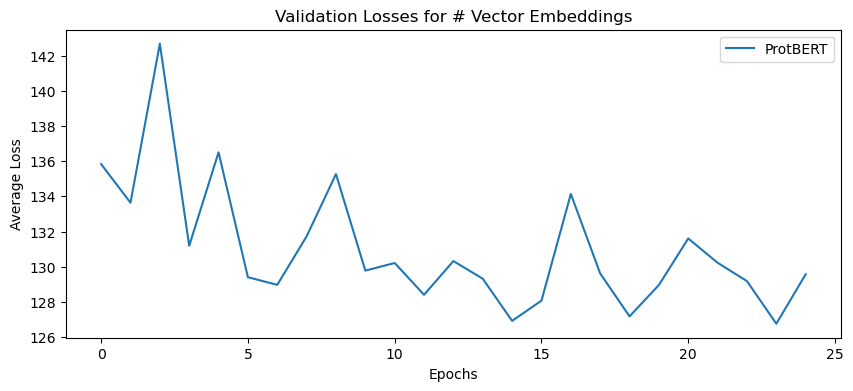

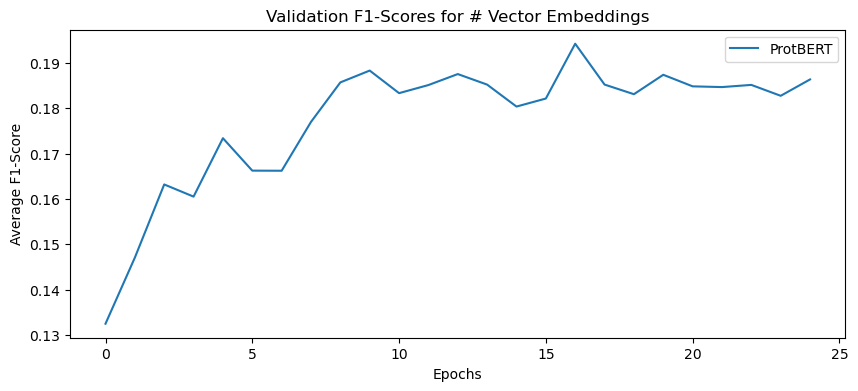

In [31]:
plt.figure(figsize = (10, 4))
plt.plot(losses_history["val"], label = "ProtBERT")
plt.title("Validation Losses for # Vector Embeddings")
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.legend()
plt.show()

plt.figure(figsize = (10, 4))
plt.plot(scores_history["val"], label = "ProtBERT")
plt.title("Validation F1-Scores for # Vector Embeddings")
plt.xlabel("Epochs")
plt.ylabel("Average F1-Score")
plt.legend()
plt.show()